In [204]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
# import tensorflow as tf
plt.style.use('dark_background')

# Read Input Image

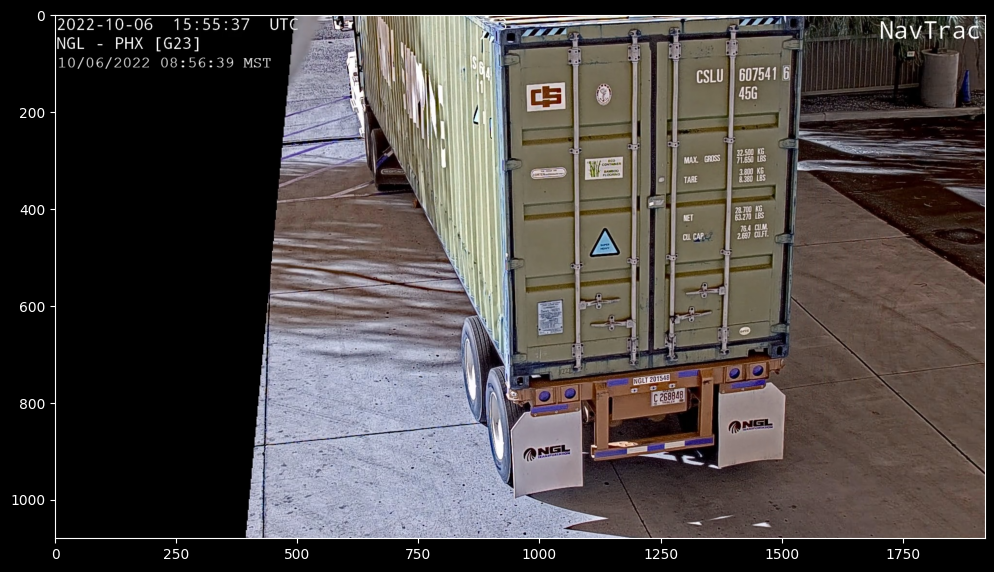

In [205]:
img_ori = cv2.imread('NAV_Noon_Samples\\CSLU6075416.jpg')

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')

# Cut the Image

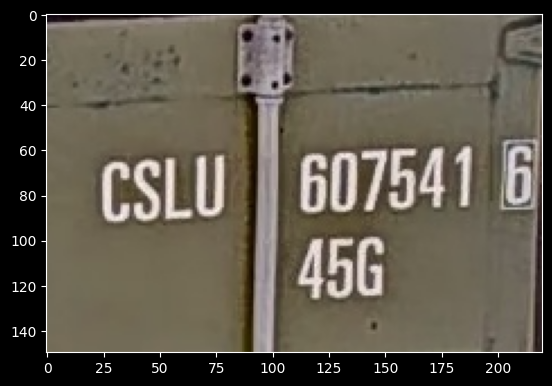

In [206]:
# img_cutted = img_ori.copy()
img_cutted = img_ori[50:200, 1300:1520]
50
200
1300
1520
height, width, channel = img_cutted.shape

# Denoise the image
# img_denoised = cv2.fastNlMeansDenoisingColored(img_cutted, None, 10,10,41,41) # original(10,10,41,41)

plt.imshow(img_cutted, cmap='gray')

# Image to Grayscale

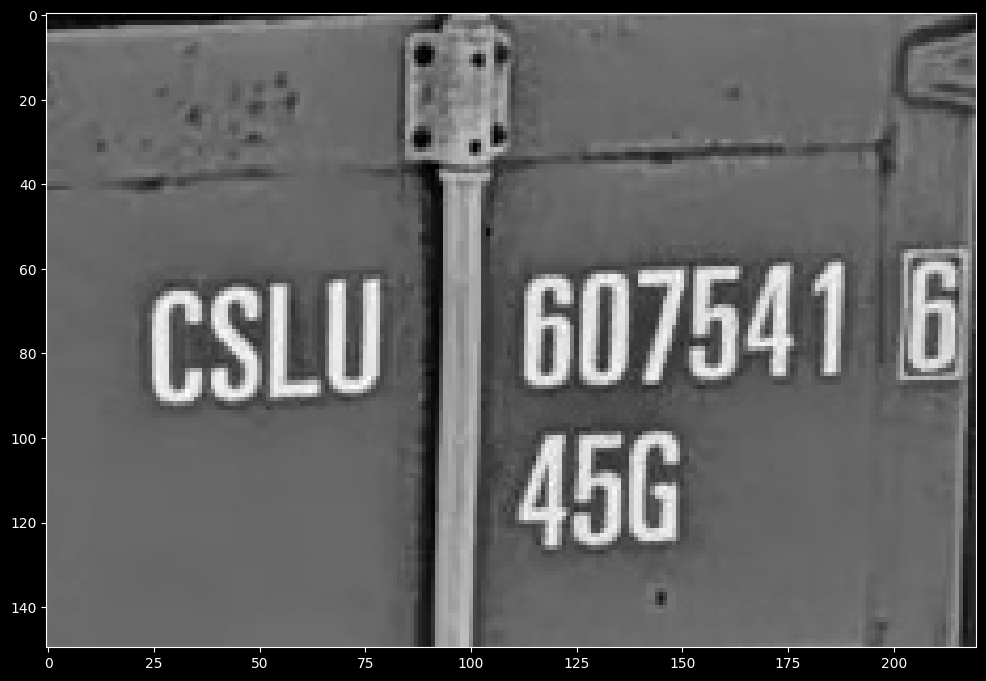

In [207]:
gray = cv2.cvtColor(img_cutted, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

# Convert Image to BlackandWhite


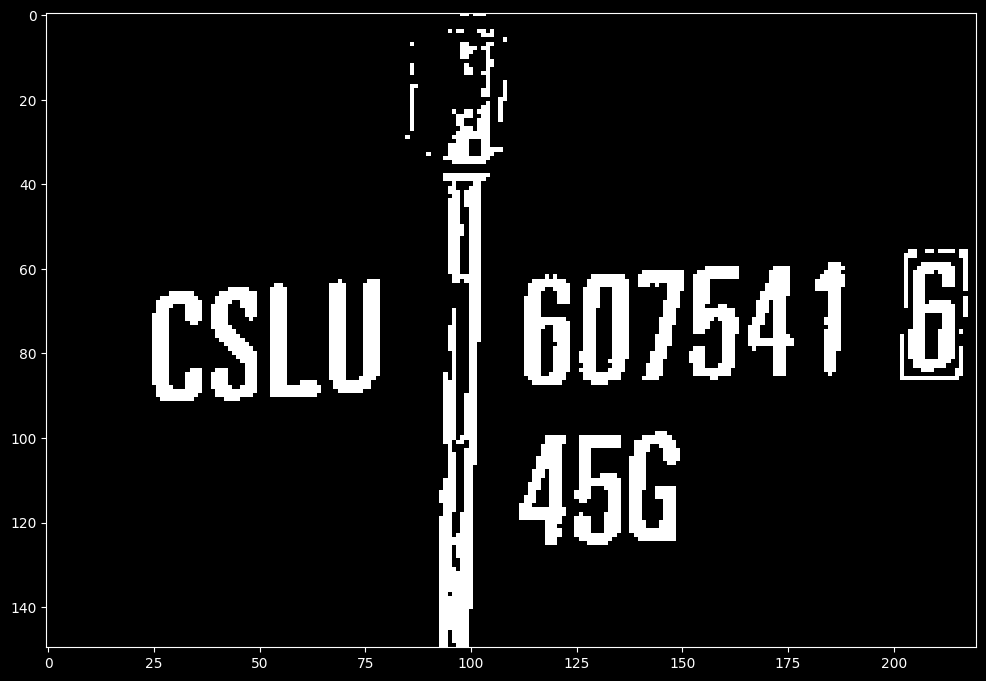

In [208]:
######################### Change the picture with Black and White #########################
# (thresh, blackAndWhiteImage) = cv2.threshold(gray, 80, 255, cv2.THRESH_BINARY)
(thresh, blackAndWhiteImage) = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
black = blackAndWhiteImage
################## Change the picture with Black and White #########################
# black = 255-black

cntr_size_black = black.copy()

plt.figure(figsize=(12, 10))
plt.imshow(black, cmap='gray')

# Find Contours

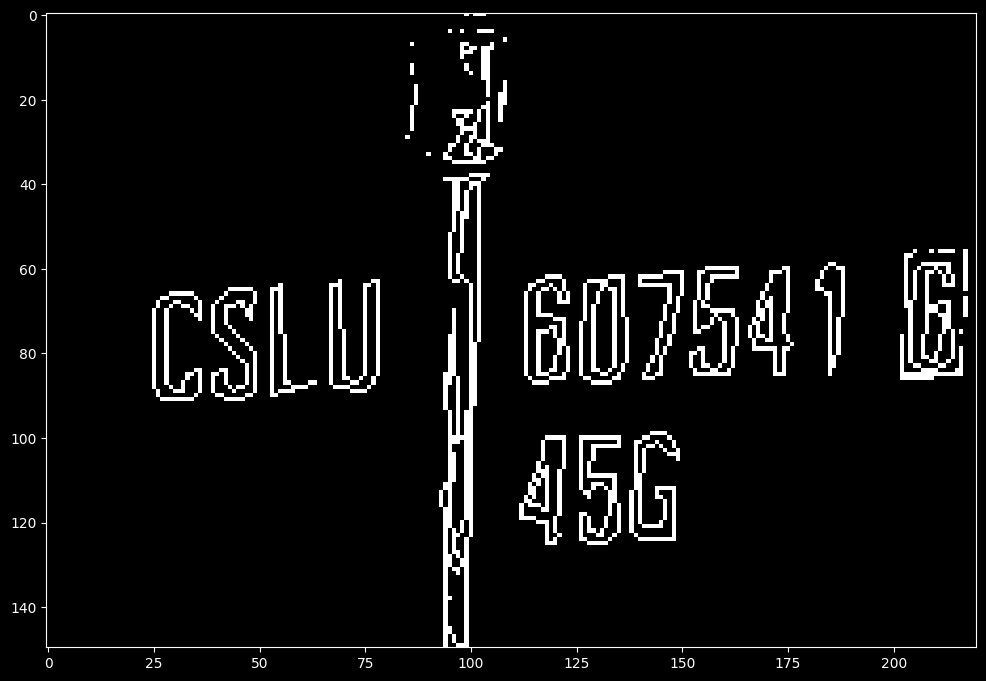

In [209]:
############# Fixed #######################################
contours, _ = cv2.findContours(
############# Fixed #######################################
    black, 
    mode=cv2.RETR_TREE,
    # method=cv2.CHAIN_APPROX_SIMPLE
    # method=cv2.CHAIN_APPROX_TC89_KCOS
    method=cv2.CHAIN_APPROX_TC89_L1
    # method=cv2.CHAIN_APPROX_NONE
)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255), thickness=1)
plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

# Prepare Data

[260, 286, 312, 312, 297, 297, 324, 312, 132, 286, 286, 286, 312, 286, 189, 125, 115]


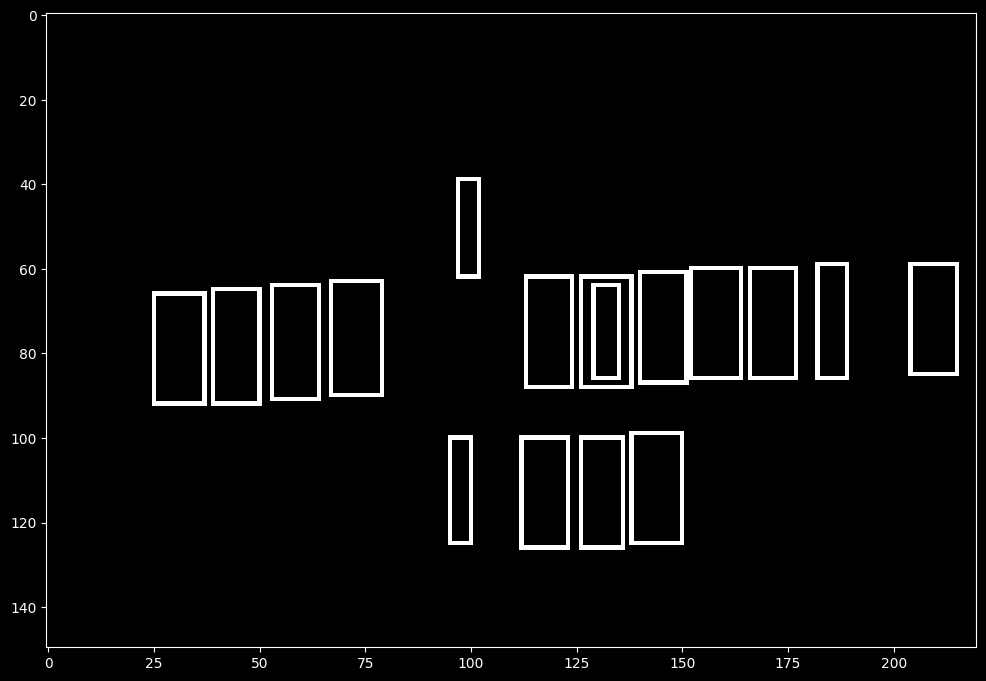

In [210]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []
area_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Delete useless contour
    if h > 40 or h < 20:
        continue
    else:
        cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=1)
        # insert to dict
        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
    })
        area_dict.append(w*h)
print(area_dict)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Image TEST

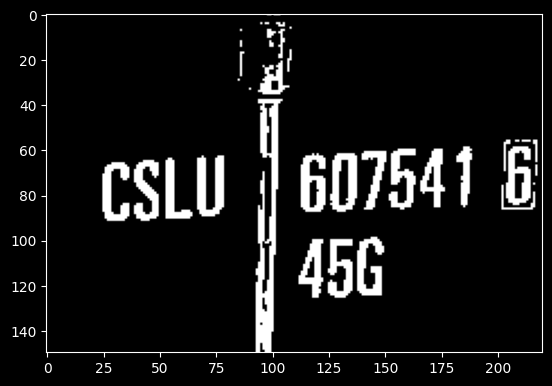

In [211]:
plt.imshow(black, cmap='gray')

# Select Candidates by Char Size

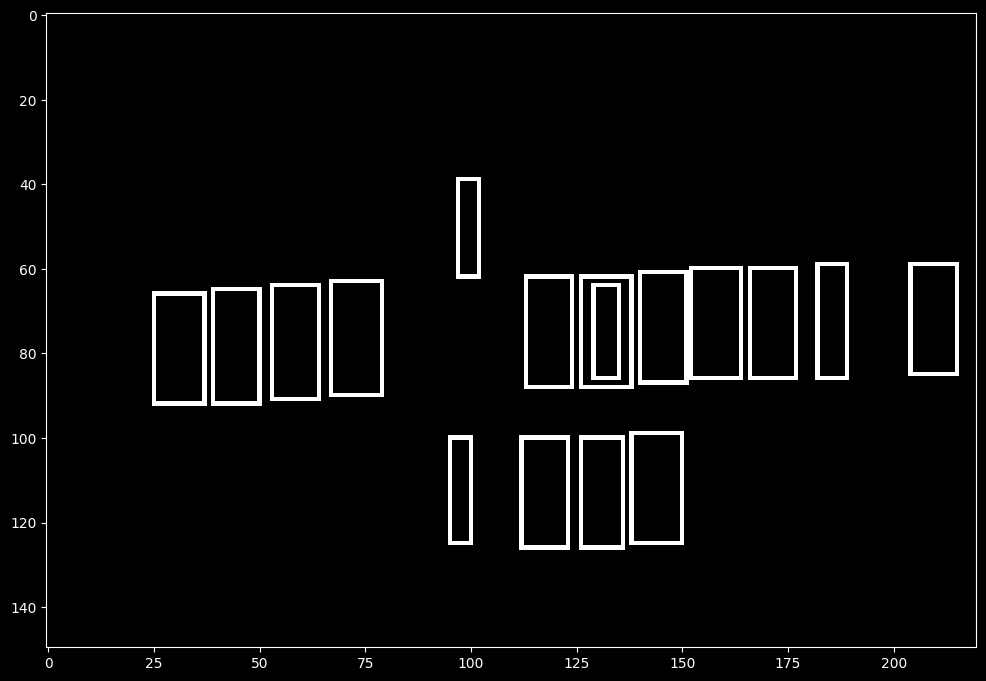

In [212]:
MIN_AREA = 100
# MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0

for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if MIN_AREA < area:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Select Candidates by Arrangement of Contours

[[25, 12, 66, 26], [39, 11, 65, 27], [53, 11, 64, 27], [67, 12, 63, 27], [113, 11, 62, 26], [126, 12, 62, 26], [129, 6, 64, 22], [140, 11, 61, 26], [152, 12, 60, 26], [166, 11, 60, 26], [182, 7, 59, 27], [204, 11, 59, 26]]
12


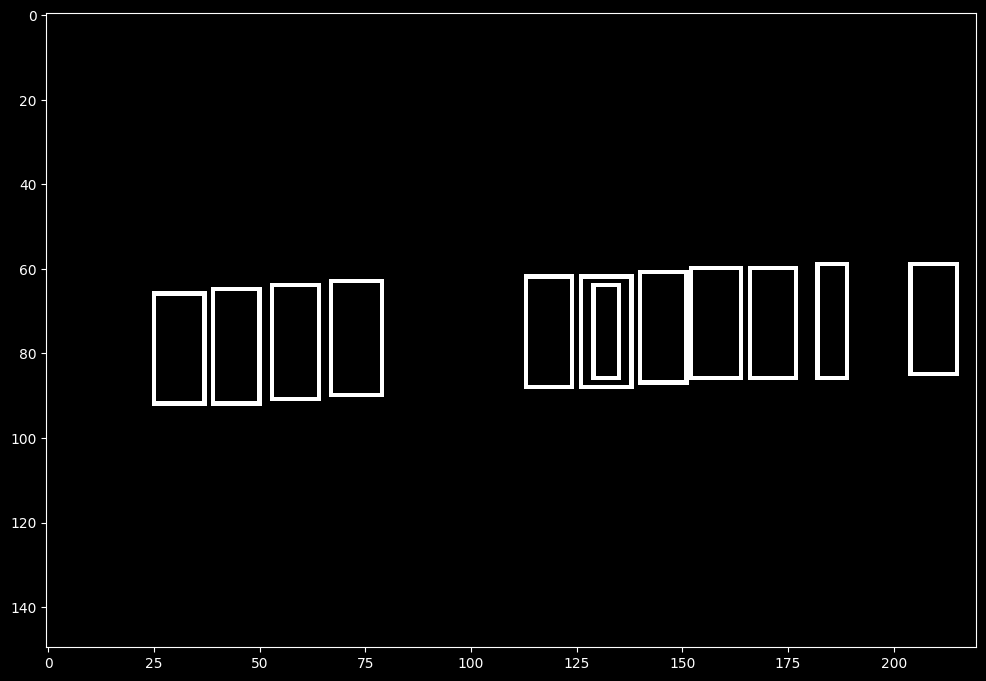

In [213]:
# MAX_DIAG_MULTIPLYER = 20 # 5 # 한 countour의 대각선길이의 몇배 안에 있어야 하는지
# MAX_ANGLE_DIFF = 8.0 # 12.0  # 기울기가 몇도이상 벌어지면 안되는지
# MIN_N_MATCHED = 5 # 12   # 컨테이너 넘버로 인정 되는 최소 개수
# MIN_DIAG_MULTIPLAYER = 3 # 한 contour의 대각선 길이의 몇배 이상 되어야 한다.
# MAX_AREA_DIFF = 0.5 # 0.5   # 면적의 차이
# MAX_WIDTH_DIFF = 3.0   # 넓이의 차이

def find_chars(contour_list, MAX_DIAG_MULTIPLYER=10, MAX_ANGLE_DIFF=10.0, MIN_N_MATCHED=8):
    matched_result_idx = []
    unmatched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []
        for d2 in contour_list:
            if d1['idx'] == d2['idx'] and d1['y'] > d2['cy']:
                continue
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)
            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx))
            # area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            # width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h'])

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)
        unmatched_contour_idx = []

        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour, MAX_DIAG_MULTIPLYER, MAX_ANGLE_DIFF, MIN_N_MATCHED)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)
        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours, MAX_DIAG_MULTIPLYER=10, MAX_ANGLE_DIFF=8.0, MIN_N_MATCHED=8)

matched_result = []

for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

last_digit = 0

list_x = []

for r in matched_result:
    for d in r:
        cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)
        list_x.append([int(d['x']), int(d['w']), int(d['y']), int(d['h'])])
list_x.sort()
print(list_x)
print(len(list_x))

# Each Side draw Black
cv2.rectangle(black, pt1=(list_x[-1][0] + 15 ,0), pt2=(width,height), color=(0,0,0), thickness=-1)

# Between Header and Serial #
for index in range(0, len(list_x)-1):
    if list_x[index+1][0] - (list_x[index][0] + list_x[index][1]) >= 20:
        cv2.rectangle(black, pt1=(list_x[index][0]+list_x[index][1]+1, 0), \
            pt2=(list_x[index+1][0]-1, list_x[index][2]+list_x[index][3]), color=(0,0,0), thickness=-1)
    
plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

# Rotate Plate Images

CSLU 607541 &

CSLU607541


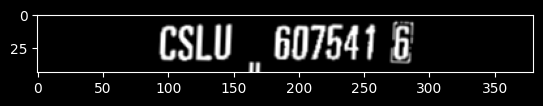

In [214]:
# PLATE_WIDTH_PADDING = 1.5 # 1.5
# PLATE_HEIGHT_PADDING = 1.7 # 1.7
# MIN_PLATE_RATIO = 3
# MAX_PLATE_RATIO = 20

def rotate_plate_img(matched_result, black,  PLATE_WIDTH_PADDING=2.0, PLATE_HEIGHT_PADDING=1.7, MIN_PLATE_RATIO=3, MAX_PLATE_RATIO=20):
    plate_imgs = []
    plate_infos = []
    chars=''
    result_chars=''
    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
        
        ordinary_plate = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x'])
        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
        side_width = (plate_width - ordinary_plate)/2

        sum_height = 0
        for d in sorted_chars:
            # print(d['idx'])
            sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )
        
        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))
        
        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)
        
        img_rotated = cv2.warpAffine(black, M=rotation_matrix, dsize=(width, height))
        
        img_cropped = cv2.getRectSubPix(
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )
        
        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue
        
        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })

        ### Plate's Side should be black ###
        img_cropped = cv2.rectangle(img_cropped, pt1=(0,0), pt2=(int(side_width)-5, plate_height), color=(0,0,0), thickness=-1)
        img_cropped = cv2.rectangle(img_cropped, pt1=(int(plate_width) - int(side_width) + 5, 0), pt2=(int(plate_width),int(plate_height)), color=(0,0,0), thickness=-1)

        chars = pytesseract.image_to_string(img_cropped, lang='eng') 
        has_digit = False

        for c in chars:
            if ord('A') <= ord(c) <= ord('Z') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c
        plt.subplot(len(matched_result), 1, i+1)
        plt.imshow(img_cropped, cmap='gray')
    return chars , result_chars, img_cropped, plate_infos

chars, result_chars, img_cropped, plate_infos = rotate_plate_img(matched_result, black)


print(chars)
print(result_chars)

# Erosion & Detect

CSLU 607541 §

CSLU607541


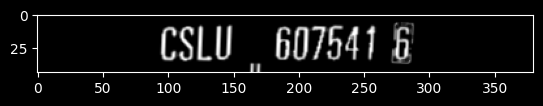

In [215]:
longest_idx, longest_text = -1, 0

# If without erode, it is clear answer, stop the function
# This function is only on Test_NAV.py

# Image erode
kernel = np.ones((2,2), np.uint8)
img_eroded = cv2.erode(img_cropped, kernel, iterations=1)

result_chars = ''
has_digit = False
process = 0

chars = pytesseract.image_to_string(img_eroded, lang='eng') 
for c in chars:
    if ord('A') <= ord(c) <= ord('Z') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(chars)
print(result_chars)

plt.imshow(img_eroded, cmap='gray')

# CNTR # Result

CSLU607541


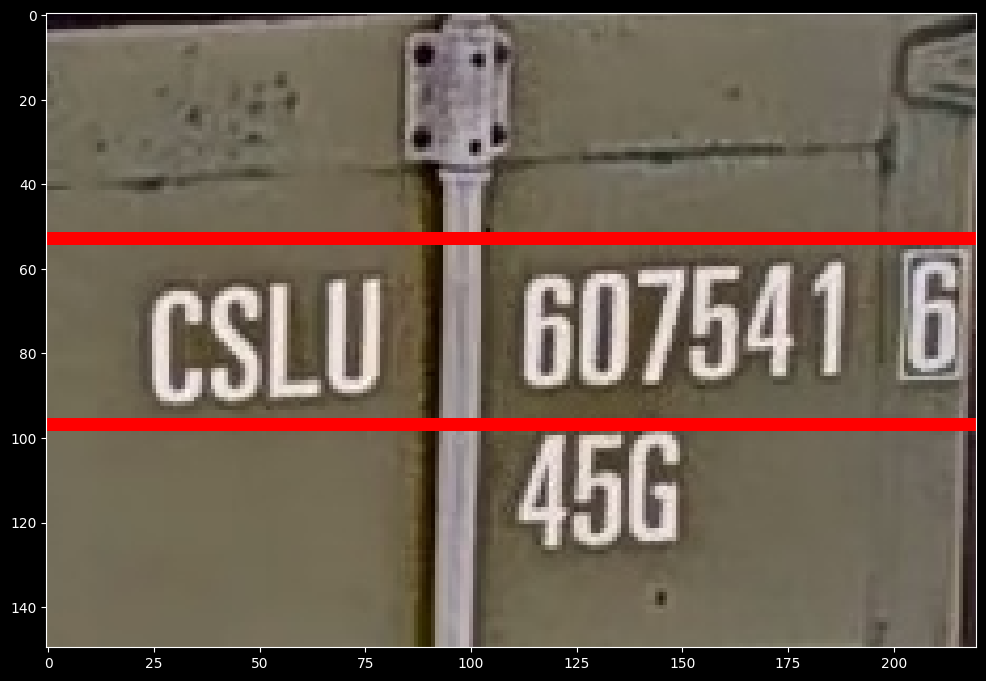

In [216]:
info = plate_infos[longest_idx]

print(result_chars)

cv2.rectangle(img_cutted, pt1=(info['x'], info['y']), pt2=(info['x']+info['w'], info['y']+info['h']), color=(255,0,0), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(img_cutted)

# CNTR SIZE

-0.03684210526315789
84.8157894736842
[[95, 5, 100, 25], [112, 11, 100, 26], [126, 10, 100, 26], [138, 12, 99, 26]]


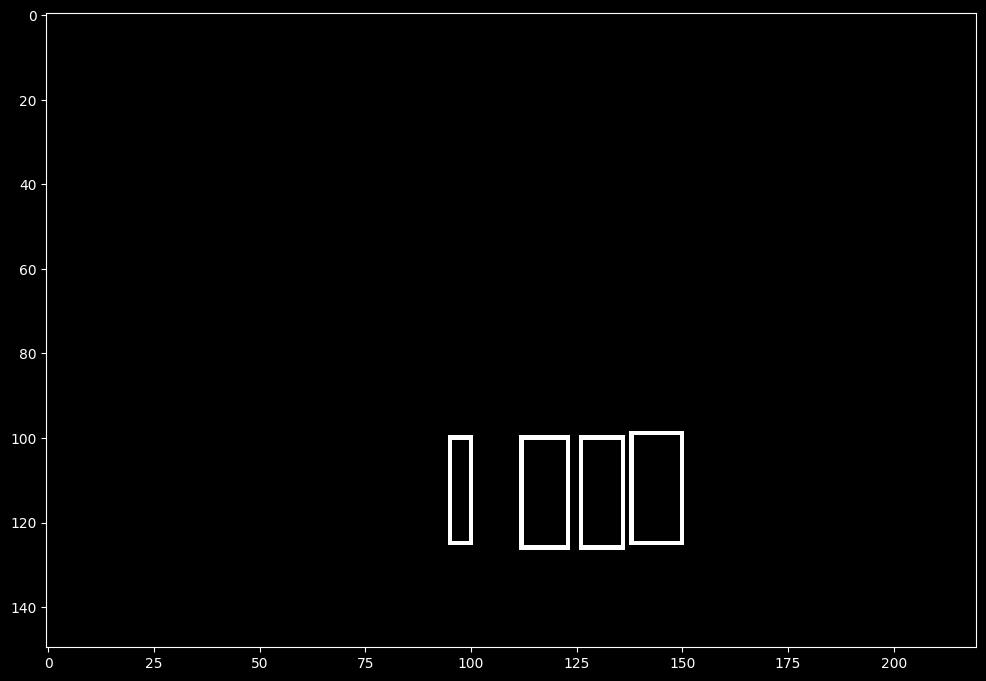

In [217]:
x = 0 # First dot for the border line
y = 0
z = 0 # Second dot for the border line
w = 0

x = list_x[0][0]
y = list_x[0][2] + list_x[0][3]
z = list_x[-1][0] + list_x[-1][1]
w = list_x[-1][2] + list_x[-1][3]

# print(list_x)
# y = inclination*x + y_intercept

inclination = (y-w)/(x-z)  # inclination
print(inclination)
y_intercept = y - inclination*x  # y_intercept
y_w_intercept = y_intercept + inclination*width # when x = width, what is y.
print(y_w_intercept)

cntr_size_list = []
cntr_size_temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cntr_size_list_x = []
for d in possible_contours:
    tmp = inclination * d['x'] + y_intercept
    if d['y'] + d['h']/2  >= tmp:
        # print("({0} + {1})/2 >= {2}".format(d['y'],d['h'],tmp))
        cntr_size_list.append(d)
        cntr_size_list_x.append([int(d['x']), int(d['w']), int(d['y']), int(d['h'])])

        cv2.rectangle(cntr_size_temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)

cntr_size_list_x.sort()
print(cntr_size_list_x)

cntr_size_result_idx = find_chars(cntr_size_list, 2, 10.0, 2)
cntr_size_matched_result = []

for idx_list in cntr_size_result_idx:
    cntr_size_matched_result.append(np.take(possible_contours, idx_list))

cntr_size_temp_result = np.zeros((height,width,channel), dtype=np.uint8)

lowest_y = 0
highest_h = 0
for r in cntr_size_matched_result:
    for d in r:
        cv2.rectangle(cntr_size_temp_result,pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=1)
        if lowest_y < d['y']:
            lowest_y = d['y']
        if d['h'] > highest_h:
            highest_h = d['h']
            
cv2.rectangle(cntr_size_black,pt1=(0,0), pt2=(width,lowest_y-5), color=(0,0,0), thickness=-1)
cv2.rectangle(cntr_size_black,pt1=(0,lowest_y + highest_h + 5), pt2=(width,height), color=(0,0,0), thickness=-1)
# cv2.rectangle(cntr_size_black, pt1=(0,cntr_size_list_x[0][2]), pt2=(cntr_size_list_x[0][0],height), color=(0,0,0), thickness=-1)


# print(cntr_size_list)
plt.figure(figsize=(12, 10))
plt.imshow(cntr_size_temp_result, cmap='gray')

# ROTATE CNTR SIZE

{{ 456

456


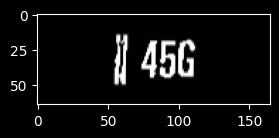

In [218]:
chars, result_chars, img_cropped, plate_infos = rotate_plate_img(cntr_size_matched_result, cntr_size_black,\
     PLATE_WIDTH_PADDING=3.0, PLATE_HEIGHT_PADDING=2.5, MIN_PLATE_RATIO=3, MAX_PLATE_RATIO=5)

chars = pytesseract.image_to_string(img_cropped, lang='eng')
for c in chars:
    if ord('A') <= ord(c) <= ord('Z') or c.isdigit():
        if c.isdigit():
            has_digit = True
        result_chars += c

print(chars)
print(result_chars)

plt.figure(figsize=(3,2))
plt.imshow(img_cropped, cmap='gray')

## JSON Extract

In [219]:
# import json

# d = dict()
# d['cntr_num'] = result_chars

# file_path = '.\JSON_API\\api.json'

# with open (file_path, 'w', encoding='UTF-8') as fp:
#     json.dump(d, fp, indent=4)